**Interactive Recursive Fractals Notebook**

November, 2019

I saw this series https://twitter.com/FogleBird/status/1198436843223695361 from @FogleBird and
wanted to recreate it in Jupyter Notebook.

To get here, I needed to stand on the shoulders of these websites.

* https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
* https://nedbatchelder.com/blog/201901/drawing_cairo_svg_in_a_jupyter_notebook.html

First, I show the code as closely as possible from the tweet.

In [1]:
import cairo
import math
import IPython.display
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from io import BytesIO

In [2]:
def draw(cr, d, x, y, s, w, a):
    nx = x + math.cos(math.radians(a)) * s
    ny = y + math.sin(math.radians(a)) * s
    cr.move_to(x,y)
    cr.line_to(nx,ny)
    cr.set_line_width(w)
    cr.stroke()
    if d == 0:
        return
    draw(cr, d-1, nx, ny, s/1.456, w/1.333, a + 90)
    draw(cr, d-1, nx, ny, s/1.456, w/1.333, a - 90)

def draw_svg(size,levels):
    svgio = BytesIO()
    with cairo.SVGSurface(svgio, size, size) as surface:
        cr = cairo.Context(surface)
        cr.set_source_rgb(1,1,1)
        cr.paint()
        cr.set_source_rgb(0,0,0)
        cr.scale(size,size)
        draw(cr, levels, 0.5, 0.5, 0.25, 0.015, 0)
        draw(cr, levels, 0.5, 0.5, 0.25, 0.015, 180)
    return IPython.display.SVG(data=svgio.getvalue())

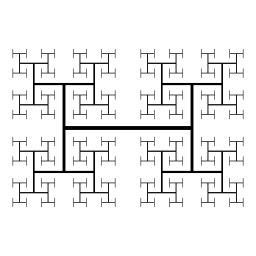

In [3]:
draw_svg(256,7)

**Parameterization & Interaction**

Nice!  Next, I wanted to parameterize and explore it interactively.

In [4]:
def draw1(cr, d, x, y, s, w, a, a0, r0, r1):
    nx = x + math.cos(math.radians(a)) * s
    ny = y + math.sin(math.radians(a)) * s
    cr.move_to(x,y)
    cr.line_to(nx,ny)
    cr.set_line_width(w)
    cr.stroke()
    if d == 0:
        return
    draw1(cr, d-1, nx, ny, s/r0, w/r1, a + a0/2, a0, r0, r1)
    draw1(cr, d-1, nx, ny, s/r0, w/r1, a - a0/2, a0, r0, r1)

def draw_svg1(size,levels,length,widthX10,rotation,angle,r0,r1):
    svgio = BytesIO()
    with cairo.SVGSurface(svgio, size, size) as surface:
        cr = cairo.Context(surface)
        cr.set_source_rgb(0.96,0.95,0.90)
        cr.paint()
        cr.set_source_rgb(0,0,0)
        cr.scale(size,size)
        draw1(cr, levels, 0.5, 0.5, length, widthX10/10, rotation+angle/2, angle, r0, r1)
        draw1(cr, levels, 0.5, 0.5, length, widthX10/10, rotation-angle/2, angle, r0, r1)
    return IPython.display.SVG(data=svgio.getvalue())

If you set num_levels=7, init_length=0.25, init_widthX10=0.15, rotation=90, split_angle=180, length_div=1.45 and width_div=1.25 you can reproduce the original.  Explore & have fun!

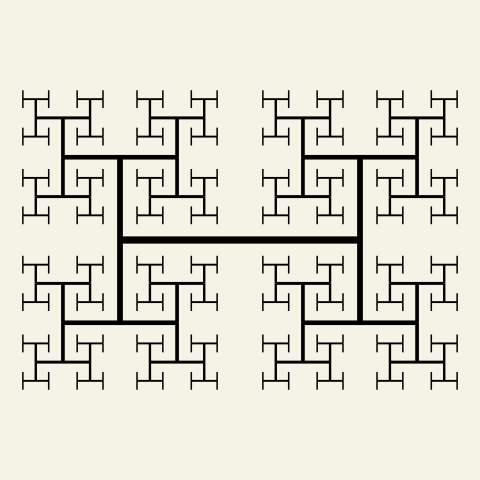

In [5]:
draw_svg1(480,7,0.25,0.15,90,180,1.45,1.25)

In [6]:
@interact
def show_drawing(num_levels=(0,12,1),
                 init_length=(0.05,0.5,0.01),
                 init_widthX10=(0.01,0.30,0.01),
                 rotation=(0,360,1),
                 split_angle=(0,180,1),
                 length_div=(1.0,4.0,0.01),
                 width_div=(1.0,2.0,0.01)):
    return draw_svg1(480,num_levels,init_length,init_widthX10,rotation,split_angle,length_div,width_div)

interactive(children=(IntSlider(value=6, description='num_levels', max=12), FloatSlider(value=0.27, descriptio…

**Quadratic Curves instead of Lines**

Next, @FogleBird made a drawing using quadratic curves.  I had to look at it closely to decipher how to recreate it.   The bottom image shows how lines are used.  The top image shows how the quadratic curve is used.

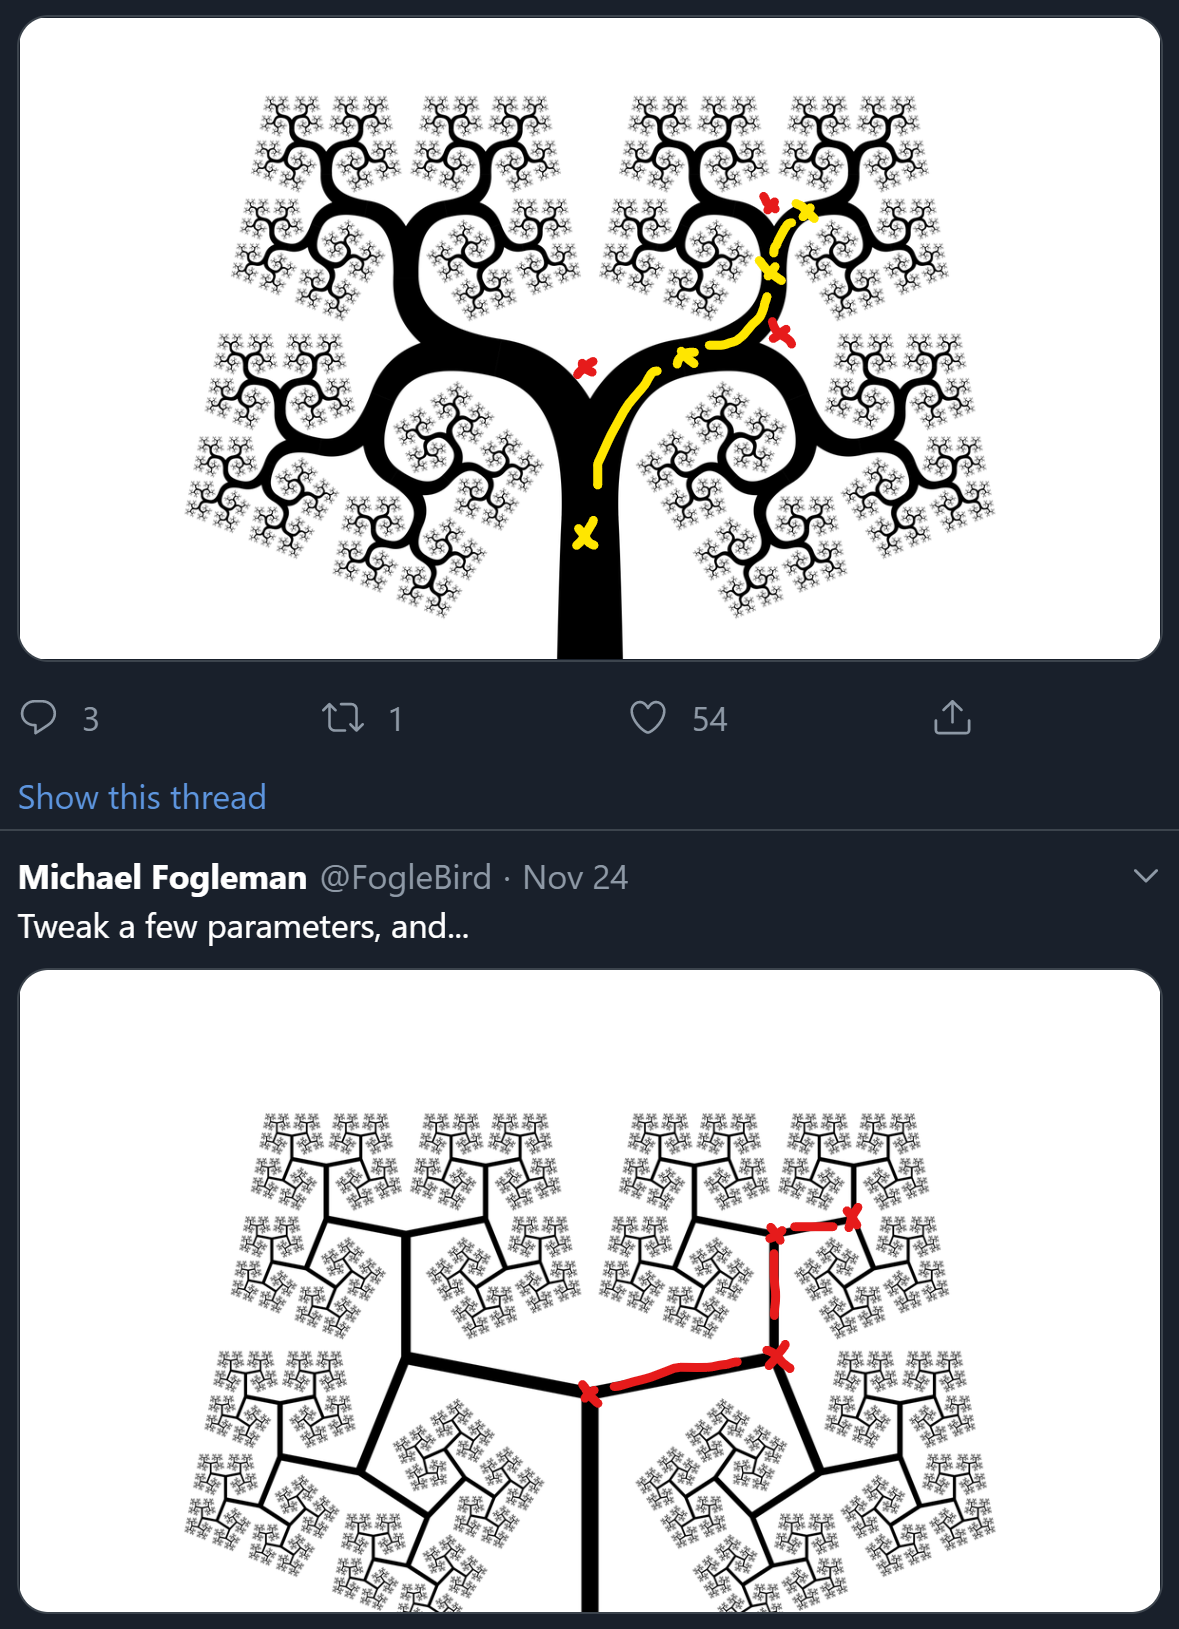

In [7]:
IPython.display.Image(filename='images/foglebird_annotated_tweets.png',width=480) 

In [8]:
# https://lists.cairographics.org/archives/cairo/2010-April/019691.html
def quadratic_to(cr, x0, y0, x1, y1, x2, y2):
  #x0, y0 = cr.get_current_point()
  cr.curve_to(2.0 / 3.0 * x1 + 1.0 / 3.0 * x0,
              2.0 / 3.0 * y1 + 1.0 / 3.0 * y0,
              2.0 / 3.0 * x1 + 1.0 / 3.0 * x2,
              2.0 / 3.0 * y1 + 1.0 / 3.0 * y2,
              x2, y2)

# the above curve is not as strong a curve...
def quadratic_to2(cr, x0, y0, x1, y1, x2, y2):
  #x0, y0 = cr.get_current_point()
  cr.curve_to(x1, y1,
              x1, y1,
              x2, y2)

# the above is too strong...hoping to make this just right?
def quadratic_to3(cr, x0, y0, x1, y1, x2, y2):
  #x0, y0 = cr.get_current_point()
  cr.curve_to(2.0 / 3.0 * x1 + 1.0 / 3.0 * x0,
              2.0 / 3.0 * y1 + 1.0 / 3.0 * y0,
              x1, y1,
              x2, y2)

def draw2(cr, d, x, y, s, w, old_a, a, a0, r0, r1):
    # previous midpoint is first endpoint of curve
    pmx = x - math.cos(math.radians(old_a)) * 1.0*r0*s/2.0
    pmy = y - math.sin(math.radians(old_a)) * 1.0*r0*s/2.0
    # midpoint is 2nd endpoint of curve
    mx = x + math.cos(math.radians(a)) * 1.0*s/2.0
    my = y + math.sin(math.radians(a)) * 1.0*s/2.0
    # nx is next control point & not used for drawing
    nx = x + math.cos(math.radians(a)) * s
    ny = y + math.sin(math.radians(a)) * s
    cr.move_to(pmx,pmy)
    quadratic_to3(cr, pmx,pmy, x,y, mx,my)
    cr.set_line_width(w)
    cr.stroke()
    if d == 0:
        return
    # in order to match the curves of the old curve & 2 new curves, the 2 new curves
    # need to be offset tangent to the current angle.
    nx_offset = math.cos(math.radians(a + 90)) * 0.25*(w/r1)
    ny_offset = math.sin(math.radians(a + 90)) * 0.25*(w/r1)
    draw2(cr, d-1, nx+nx_offset, ny+ny_offset, s/r0, w/r1, a, a + a0/2, a0, r0, r1)
    draw2(cr, d-1, nx-nx_offset, ny-ny_offset, s/r0, w/r1, a, a - a0/2, a0, r0, r1)

def draw_svg2(size,levels,length,widthX10,rotation,angle,r0,r1):
    svgio = BytesIO()
    with cairo.SVGSurface(svgio, size, size) as surface:
        cr = cairo.Context(surface)
        cr.set_source_rgb(0.96,0.95,0.90)
        cr.paint()
        cr.set_source_rgb(0,0,0)
        cr.scale(size,size)
        cr.set_line_cap(cairo.LineCap.SQUARE)
        draw2(cr, levels, 0.5, 0.5, length, widthX10/10, rotation, rotation+angle/2, angle, r0, r1)
        draw2(cr, levels, 0.5, 0.5, length, widthX10/10, rotation, rotation-angle/2, angle, r0, r1)
    return IPython.display.SVG(data=svgio.getvalue())

Trying to match his drawing, seems like this is close.
init_length=0.19, init_width=0.40, rotation=270, split_angle=154, length_div=1.54, width_div=1.54

In [9]:
draw_svg2(480,12,0.19,0.40,270,154,1.54,1.54)

In [10]:
@interact
def show_drawing(num_levels=(0,12,1),
                 init_length=(0.05,0.5,0.01),
                 init_widthX10=(0.1,0.5,0.01),
                 rotation=(0,360,1),
                 split_angle=(0,180,1),
                 length_div=(1.0,4.0,0.01),
                 width_div=(1.0,2.0,0.01)):
    return draw_svg2(480,num_levels,init_length,init_widthX10,rotation,split_angle,length_div,width_div)

interactive(children=(IntSlider(value=6, description='num_levels', max=12), FloatSlider(value=0.27, descriptio…